In [33]:
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import time
from pylab import *
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage.util.shape import view_as_windows
from sklearn.metrics import roc_curve,roc_auc_score
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Conv2D, Layer, Lambda, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
train_source = os.path.abspath(os.path.join('../../data/train_source/'))
test_source = os.path.abspath(os.path.join('../../data/test_source/'))
train_path = os.path.abspath(os.path.join('../../data/train/'))
test_path = os.path.abspath(os.path.join('../../data/test/'))
dest_path_bsu = os.path.abspath(os.path.join('../../data/final_bsu/'))
dest_path_bs = os.path.abspath(os.path.join('../../data/final_bs/'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
    
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
#print(device_lib.list_local_devices())

In [66]:
# Hyperparameters
nb_classes=2
cols, rows = 2, 30
input_shape = (cols, rows, 1)
vol_imb_diff = 0.1
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
num_frames = 10
h = 30
w = 2
d = 2

In [8]:
X_train = np.load(dest_path_bs + '/' + str(num_frames) + '_X_train.npy')
Y_train = np.load(dest_path_bs + '/' + str(num_frames) + '_Y_train.npy')
F_train = np.load(dest_path_bs + '/' + str(num_frames) + '_F_train.npy')
X_test = np.load(dest_path_bs + '/' + str(num_frames) + '_X_test.npy')
Y_test = np.load(dest_path_bs + '/' + str(num_frames) + '_Y_test.npy')
F_test = np.load(dest_path_bs + '/' + str(num_frames) + '_F_test.npy')

### Model Initialisation

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

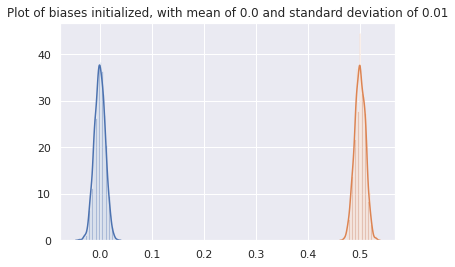

In [35]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [36]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 30, 2, 2)]    0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 10, 120)           0         
_________________________________________

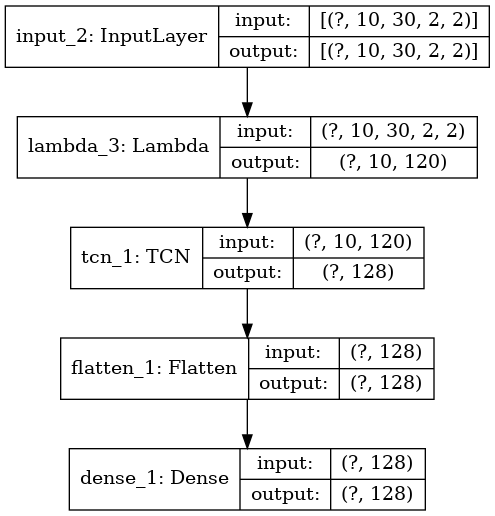

In [37]:
def embedding_model(frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None, classes=1):  
    inp = Input(shape=(frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(inp)
    out = TCN(nb_filters=128, kernel_size=2, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32, 64], 
              activation=tf.keras.activations.swish, nb_stacks=1, dropout_rate=0.08)(out)
    out = Flatten()(out)
    out = Dense(128, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(out)    
    return Model(inputs=inp, outputs=out)

def triplets_model(input_shape, embedding, include_top=False, pooling=None):

    anchor_input = Input(shape=input_shape, name='anchor_input')
    positive_input = Input(shape=input_shape, name='positive_input')
    negative_input = Input(shape=input_shape, name='negative_input')

    # Get the embedded values
    encoded_a = embedding(anchor_input)
    encoded_p = embedding(positive_input)
    encoded_n = embedding(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    # Connect the inputs with the outputs
    triplet_net = Model(inputs=[anchor_input,positive_input,negative_input],outputs=[loss_layer])
    return triplet_net

build_embedding = embedding_model(num_frames, 30, w, d, input_shape=(num_frames, 30, w, d), dimensions=60)
build_triplet = triplets_model(input_shape=(num_frames, 30, w, d), embedding=build_embedding)
optimizer = Adam(lr = 0.00006)
build_triplet.compile(loss=[None],optimizer=optimizer,sample_weight_mode="temporal")
build_embedding.summary()
build_triplet.summary()
#print(build_triplet.metrics_names)
tcn_full_summary(build_embedding, expand_residual_blocks=True)
plot_model(build_embedding, 'multi_input_and_output_model.png', show_shapes=True)

### Training Triplet Net

In [62]:
def get_triplet_batch_spoof(batch_size, lob_states, labels, features):
    n_examples, t, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, t, h, w, d)) for i in range(3)]
    feature_weight = [np.zeros(batch_size) for i in range(3)]
    class_labels = [np.zeros(batch_size) for i in range(3)]
    
    labels_b = labels[labels==1]
    labels_s = labels[labels==2]
   # print(labels_b.shape)
   # print(labels_u.shape)
    #print(labels_b.shape)
    #print(labels_s.shape)
    for i in range(batch_size):
        if (i%2==0):
            idx_a = np.random.choice(labels_b.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_b.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_s.shape[0], 1, replace=False)
        else:
            idx_a = np.random.choice(labels_s.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_s.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_b.shape[0], 1, replace=False)
        
        feature_weight[0][i] = features[idx_a]
        feature_weight[1][i] = features[idx_p]
        feature_weight[2][i] = features[idx_n]
        
        class_labels[0][i] = labels[idx_a]
        class_labels[1][i] = labels[idx_p]
        class_labels[2][i] = labels[idx_n]
        
        triplets[0][i,:,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:,:] = lob_states[idx_n]
        
    return [triplets[0], triplets[1], triplets[2]], [class_labels[0], class_labels[1], class_labels[2]], \
           [feature_weight[0], feature_weight[1], feature_weight[2]]

def get_triplet_batch_spoof_ooo(batch_size, lob_states, labels, features):
    n_examples, t, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, t, h, w, d)) for i in range(3)]
    feature_weight = [np.zeros(batch_size) for i in range(3)]
    class_labels = [np.zeros(batch_size) for i in range(3)]
    
    labels_b = labels[labels==1]
    labels_s = labels[labels==2]

    for i in range(batch_size):
        if (i%2==0):
            idx_a = np.random.choice(labels_b.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_b.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_s.shape[0], 1, replace=False)
        else:
            idx_a = np.random.choice(labels_s.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_s.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_b.shape[0], 1, replace=False)
        
        feature_weight[0][i] = features[idx_a]
        feature_weight[1][i] = features[idx_p]
        feature_weight[2][i] = features[idx_n]
        
        class_labels[0][i] = labels[idx_a]
        class_labels[1][i] = labels[idx_p]
        class_labels[2][i] = labels[idx_n]
        
        triplets[0][i,:,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:,:] = lob_states[idx_n]
        
    return [np.array([triplets[0]]),np.array([triplets[1]]), np.array([triplets[2]])], \
           [class_labels[0], class_labels[1], class_labels[2]], \
           [np.array([feature_weight[0]]), np.array([feature_weight[1]]), np.array([feature_weight[2]])]

def get_triplet_batch_spoof_three(batch_size, lob_states, labels, features):
    n_examples, t, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, t, h, w, d)) for i in range(3)]
    feature_weight = [np.zeros(batch_size) for i in range(3)]
    class_labels = [np.zeros(batch_size) for i in range(3)]
    
    labels_u = labels[labels==0]
    labels_b = labels[labels==1]
    labels_s = labels[labels==2]

    for i in range(batch_size):
        if (i%5==0):
            idx_a = np.random.choice(labels_b.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_b.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_s.shape[0], 1, replace=False)
        elif (i%5==1):
            idx_a = np.random.choice(labels_b.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_b.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_u.shape[0], 1, replace=False)
        elif (i%5==2):
            idx_a = np.random.choice(labels_s.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_s.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_b.shape[0], 1, replace=False)
        elif (i%5==3):
            idx_a = np.random.choice(labels_s.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_s.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_u.shape[0], 1, replace=False)
        elif (i%5==4):
            idx_a = np.random.choice(labels_u.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_u.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_b.shape[0], 1, replace=False)
        else:
            idx_a = np.random.choice(labels_u.shape[0], 1, replace=False)
            idx_p = np.random.choice(labels_u.shape[0], 1, replace=False)
            idx_n = np.random.choice(labels_s.shape[0], 1, replace=False)
   
        
        feature_weight[0][i] = features[idx_a]
        feature_weight[1][i] = features[idx_p]
        feature_weight[2][i] = features[idx_n]
        
        class_labels[0][i] = labels[idx_a]
        class_labels[1][i] = labels[idx_p]
        class_labels[2][i] = labels[idx_n]
        
        triplets[0][i,:,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:,:] = lob_states[idx_n]
        
    return [triplets[0], triplets[1], triplets[2]], [class_labels[0], class_labels[1], class_labels[2]]#, \
          # [feature_weight[0], feature_weight[1], feature_weight[2]]

#get_triplet_batch_spoof(1, X_train, Y_train, X_feature)

def triplet_generator_spoof(batch_size, X_train, Y_train, F_train):
    while True:
        triplets, labels, features = get_triplet_batch_spoof(batch_size, X_train, Y_train, F_train)
        yield (triplets, labels, features)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[-0.00394406 -0.2080246  -0.2732389   0.38304853  0.08065999  0.5596524
  0.143011    0.01256787 -0.2316595   0.14325376  0.06641181  0.56313276
 -0.3762748  -0.22474073  0.3712708  -0.05940044 -0.67717123  0.32766396
 -0.15617973 -0.37742797 -0.18693072 -0.09913778 -0.04538825  0.0223484
 -0.20917267  0.04862541  0.04934735  0.29807615 -0.13992316  0.2163399
 -0.27787253  0.16735734 -

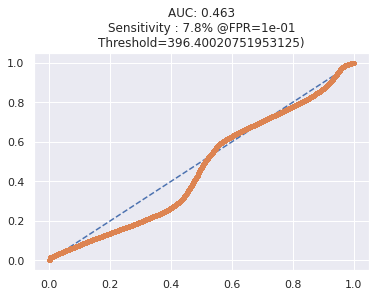

In [39]:
from scipy.spatial import distance

def compute_dist(a,b):
    return distance.cityblock(a,b)
    #return distance.correlation(a,b) -- NOT GOOD
    #return distance.cosine(a,b) -- NOT GOOD
    
    #return distance.euclidean(a,b)

    # Standard distance used 
    #return np.sum(np.square(a-b))

def compute_metrics(probs, yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no 
        instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
   
    return fpr, tpr, thresholds, auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes, num_frames, rows, cols, d))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = X_test[i,:,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))
    plt.show()
    
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=0.1
    _, idx = find_nearest(fpr, targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold)))
    # show the plot
    plt.show()
    
def compute_probs(network, X, Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m, num_frame, h, w, 1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    print(embeddings[1])
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for 
                # right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
               # print(probs[k])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs, y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

class call_back(tf.keras.callbacks.Callback):
    probs, yprob = compute_probs(build_embedding, X_test[:1000,:,:,:,:], Y_test[:1000])
    fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
    draw_roc(fpr, tpr, thresholds, auc)
   # draw_interdist(build_embedding, n_iteration)

In [71]:
train_gen = triplet_generator_spoof(batch_size, X_train, Y_train, F_train)
history = build_triplet.fit(train_gen, epochs=10, steps_per_epoch=200)

Epoch 1/10
200/200 [==============================] - 57s 284ms/step - loss: 47624.4258
Epoch 2/10
200/200 [==============================] - 57s 284ms/step - loss: 47910.7383
Epoch 3/10
200/200 [==============================] - 57s 284ms/step - loss: 43973.3398
Epoch 4/10
200/200 [==============================] - 57s 284ms/step - loss: 41391.7109
Epoch 5/10
200/200 [==============================] - 57s 284ms/step - loss: 37685.6094
Epoch 6/10
200/200 [==============================] - 57s 283ms/step - loss: 36162.4336
Epoch 7/10
200/200 [==============================] - 57s 284ms/step - loss: 33065.3906
Epoch 8/10
200/200 [==============================] - 57s 284ms/step - loss: 30723.9277
Epoch 9/10
200/200 [==============================] - 57s 284ms/step - loss: 29428.1816
Epoch 10/10
200/200 [==============================] - 57s 283ms/step - loss: 26557.1719


Starting training process!!
-------------------------------------

 ------------- 

[100] Time for 100 iterations: 0.6 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650b7a7d0>
[ 0.02131209 -0.00757446 -0.01879063  0.02008426 -0.03309249  0.01550142
 -0.00447094  0.00141693 -0.00855848  0.00494152  0.00465704  0.02600234
 -0.01746459 -0.00517869  0.02648339 -0.01131554 -0.04454061  0.01479973
 -0.03322127 -0.0041096  -0.01512345  0.00012002 -0.02921401 -0.03665697
 -0.00856076 -0.02981774 -0.00956691  0.03128754 -0.00460029  0.02149526
 -0.03196876 -0.01505454 -0.03328664 -0.02707438 -0.0249145  -0.02528818
  0.01311466 -0.00124472  0.00919333 -0.01487417 -0.00546082  0.0007981
 -0.02731446 -0.01288547  0.03217829 -0.00325436  0.02504122 -0.01348433
 -0.04525277  0.02934167 -0.01971876 -0.02248765 -0.00779914 -0.01139977
 -0.02370015 -0.02214402  0.04707585  0.00299654 -0.00655045  0.00186075
 -0.01626502 -0.01331264 -0.02314924  0.02329164 -0.03317656  0.0

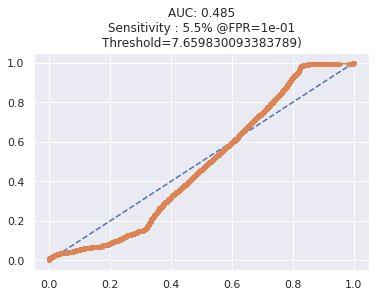

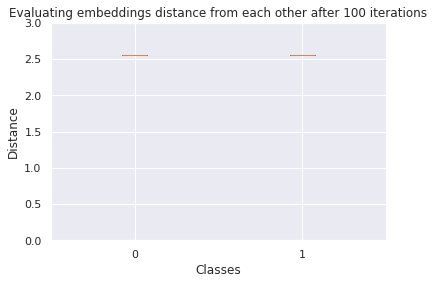


 ------------- 

[200] Time for 200 iterations: 1.3 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a65075fd10>
[ 0.02149566 -0.00549913 -0.01568103  0.01700305 -0.03009845  0.00882205
 -0.00507995  0.00005191 -0.00674847  0.00404172  0.00555913  0.02210749
 -0.0160009  -0.00309766  0.02410267 -0.01392655 -0.04038883  0.01337067
 -0.03192682 -0.00189756 -0.01502389  0.00192654 -0.0285281  -0.03532691
 -0.00777291 -0.02710915 -0.01167117  0.02678243 -0.00242959  0.01804797
 -0.03154782 -0.01277544 -0.03223452 -0.02738249 -0.02283829 -0.01982991
  0.01459721 -0.0030984   0.00741235 -0.01525254 -0.00623462  0.00019937
 -0.02581579 -0.01148268  0.02963838 -0.00836629  0.02186169 -0.01272325
 -0.04043384  0.0273386  -0.01934642 -0.01640852 -0.01010779 -0.00541907
 -0.02451762 -0.01954133  0.03820642  0.0023954  -0.0074281  -0.00089467
 -0.01466903 -0.01100801 -0.02075628  0.01961743 -0.03108224  0.01527852
 -0.01074357 -0.00384777 -0.01545442 -0.02105047  0.01803

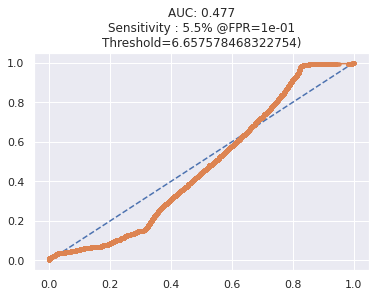

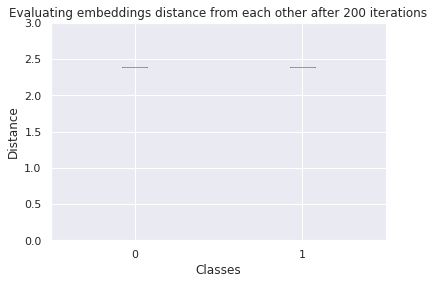


 ------------- 

[300] Time for 300 iterations: 2.0 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a6503ba3d0>
[ 0.02123458 -0.00450014 -0.01549067  0.01278487 -0.02845769  0.00630436
 -0.0045185   0.00042511 -0.00510182  0.00387397  0.00736558  0.01880291
 -0.01547273 -0.00184604  0.02331315 -0.01586718 -0.03623218  0.01076945
 -0.03118324 -0.0006373  -0.01457869  0.00170095 -0.02664689 -0.03302089
 -0.00560747 -0.02521114 -0.01247312  0.02381431 -0.00292594  0.01493568
 -0.03050371 -0.01277486 -0.03327136 -0.02723104 -0.02085597 -0.01500009
  0.01480607 -0.00388215  0.00528624 -0.01449305 -0.00615068 -0.00089601
 -0.02628764 -0.01089155  0.02834938 -0.01078226  0.02032378 -0.01252581
 -0.03826229  0.02543543 -0.01945424 -0.01219765 -0.01225828 -0.0015645
 -0.02517859 -0.01594761  0.03141972  0.00242773 -0.00822732 -0.00126313
 -0.01313703 -0.00728351 -0.01799623  0.01740643 -0.02737664  0.0125349
 -0.00691757 -0.00158357 -0.014084   -0.0185189   0.0160266

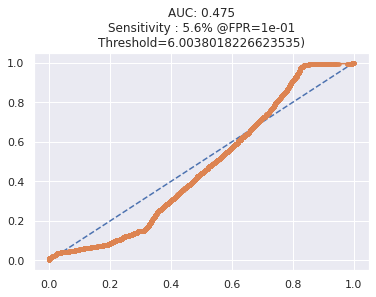

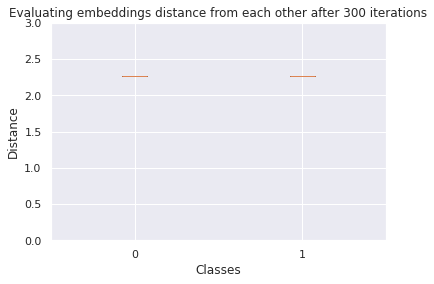


 ------------- 

[400] Time for 400 iterations: 2.7 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a65029dd10>
[ 0.02020956 -0.00288254 -0.01476103  0.01077751 -0.02628536  0.00264215
 -0.00439209 -0.00084417 -0.00356982  0.00267871  0.00793012  0.01794181
 -0.01649373 -0.00096626  0.02230989 -0.01554316 -0.03445038  0.01081966
 -0.03001388 -0.00018996 -0.01389796  0.00300818 -0.02496805 -0.03041943
 -0.00350368 -0.02240737 -0.01297672  0.02154614 -0.00369637  0.0133407
 -0.0289616  -0.01100961 -0.03315379 -0.02921997 -0.01885965 -0.01135379
  0.01466913 -0.00473498  0.00481872 -0.0135983  -0.0057039  -0.00106365
 -0.02610822 -0.01142686  0.02560283 -0.01113102  0.01899001 -0.01214541
 -0.03536923  0.02375037 -0.02066332 -0.00857811 -0.01240699  0.00235123
 -0.02559454 -0.01392971  0.02763957  0.00111585 -0.00822216 -0.00179692
 -0.01024212 -0.00447392 -0.01452293  0.01437315 -0.02670554  0.01030228
 -0.00405178 -0.00119316 -0.01349696 -0.01627413  0.014271

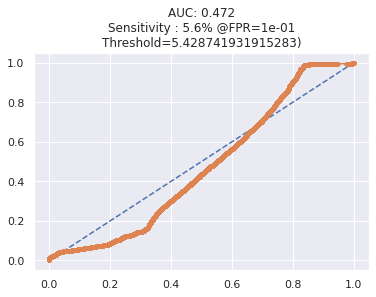

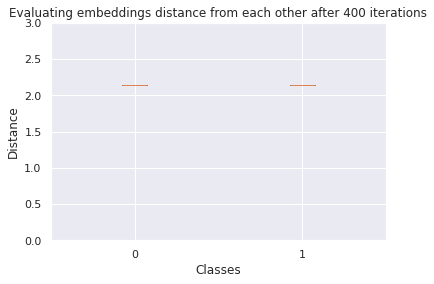


 ------------- 

[500] Time for 500 iterations: 3.4 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650a78d50>
[ 0.01887047 -0.00668415 -0.01568439  0.00921736 -0.02547804  0.00197013
 -0.00389853  0.00046982 -0.00412144  0.00332147  0.00995464  0.01531281
 -0.01639691  0.00043864  0.02163214 -0.01464641 -0.03176056  0.00984667
 -0.02958582  0.00111005 -0.01180661  0.00237391 -0.02397623 -0.02898879
 -0.00439032 -0.02226785 -0.01482599  0.01942083 -0.00480427  0.01275322
 -0.02889381 -0.0093322  -0.03287882 -0.02908447 -0.01811061 -0.00764264
  0.01493867 -0.00230501  0.00368634 -0.01231901 -0.00428972  0.00034018
 -0.02615136 -0.01043716  0.02621051 -0.01239327  0.01772214 -0.01167677
 -0.03402528  0.02136995 -0.01834798 -0.00739263 -0.01351712  0.00114711
 -0.0255063  -0.01252903  0.02436062  0.0018734  -0.00567061 -0.00259995
 -0.00801107 -0.00399509 -0.01357494  0.01265877 -0.0250213   0.00938518
 -0.00290957 -0.00132022 -0.01132458 -0.01556364  0.01343

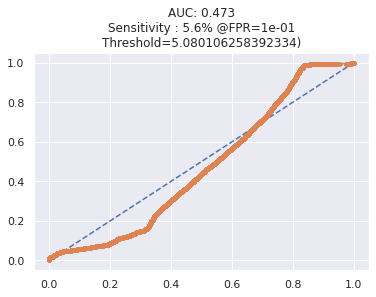

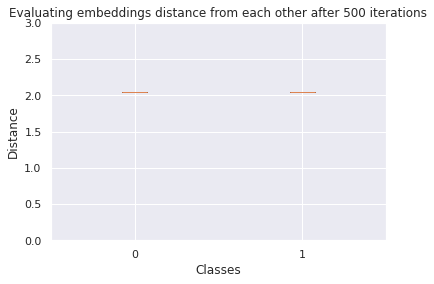


 ------------- 

[600] Time for 600 iterations: 4.1 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650430c10>
[ 0.01742118 -0.00555695 -0.01450664  0.00907231 -0.02261792 -0.00055575
 -0.00411733  0.00106999 -0.00325952  0.00307132  0.00887807  0.01138301
 -0.01769783  0.00060627  0.01987792 -0.0150932  -0.03076083  0.00828482
 -0.02861527  0.00178298 -0.01070099  0.00130978 -0.02304222 -0.02722851
 -0.00196556 -0.02257419 -0.01324288  0.01733655 -0.00257307  0.01036945
 -0.02662325 -0.00845587 -0.03154909 -0.02821884 -0.0167927  -0.00497609
  0.01504308 -0.00023591  0.00417966 -0.01229916 -0.00439822  0.00086095
 -0.02538833 -0.01158692  0.02475406 -0.01296099  0.01621124 -0.01132597
 -0.03105373  0.01957634 -0.01784094 -0.00621147 -0.01468115  0.00175338
 -0.02486868 -0.01288763  0.0225966   0.00072485 -0.00492451 -0.00326286
 -0.00626718 -0.00387945 -0.01120486  0.01212259 -0.02257521  0.01016141
 -0.00341636 -0.00035739 -0.01216374 -0.01449668  0.01362

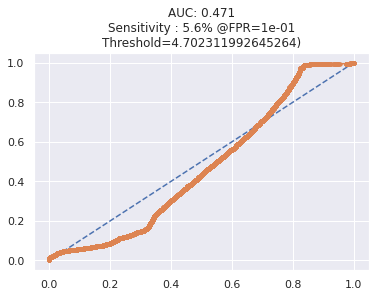

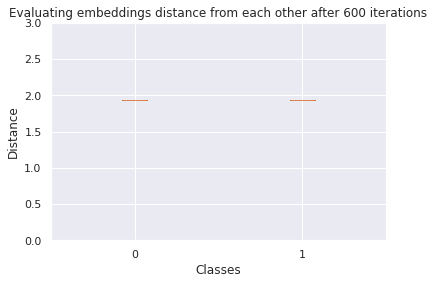


 ------------- 

[700] Time for 700 iterations: 4.8 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650f04ad0>
[ 0.0157221  -0.00522181 -0.01301251  0.0088611  -0.02128507 -0.00238061
 -0.00418823 -0.00068135 -0.00311505  0.0044426   0.0093273   0.00969607
 -0.01880128  0.0010964   0.01812392 -0.01534843 -0.03083246  0.0067267
 -0.02772779  0.0015557  -0.01077648  0.00289089 -0.02186682 -0.02608364
 -0.0018343  -0.02022368 -0.01316001  0.01563248 -0.00244823  0.00862212
 -0.02636359 -0.00775379 -0.03009746 -0.02737018 -0.01611651 -0.00428992
  0.01438317  0.00018032  0.00345073 -0.01246898 -0.00521159  0.00155814
 -0.02404043 -0.01068326  0.02233362 -0.01313186  0.01560708 -0.0110015
 -0.02780659  0.01976074 -0.01819233 -0.00280936 -0.01437533  0.00319541
 -0.02328288 -0.0127663   0.02051446 -0.0007365  -0.00388684 -0.00497083
 -0.00385321 -0.00335435 -0.01156355  0.00958108 -0.02188175  0.00965332
 -0.00300001 -0.0005631  -0.01319106 -0.01227781  0.0123622

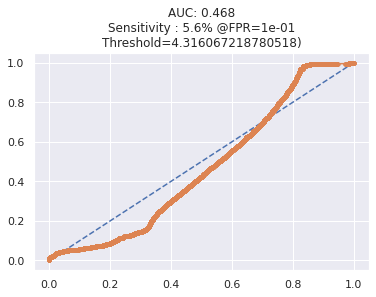

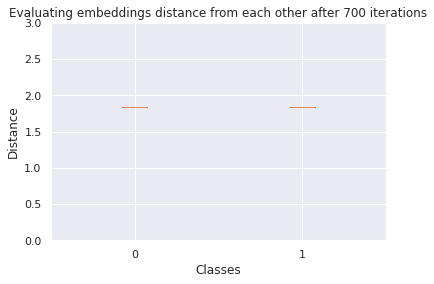


 ------------- 

[800] Time for 800 iterations: 5.5 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a63f011710>
[ 0.01410156 -0.00461052 -0.01288896  0.00837701 -0.02028542 -0.00396913
 -0.00430361 -0.00115156 -0.0016499   0.00611049  0.01094525  0.00872249
 -0.01825116  0.00150999  0.0167324  -0.0154204  -0.0296497   0.00530742
 -0.0269541   0.00087987 -0.01058923  0.00488917 -0.019801   -0.02596905
 -0.00157781 -0.01936623 -0.01331636  0.01510536 -0.00255991  0.00764553
 -0.02560457 -0.00756379 -0.02950072 -0.0268809  -0.01607923 -0.00282425
  0.01381218  0.00152494  0.00393771 -0.0121659  -0.00459361  0.00120419
 -0.0228684  -0.01108999  0.0219133  -0.01397459  0.01598853 -0.01012777
 -0.02584217  0.01784552 -0.01710278 -0.00188909 -0.01517925  0.00351207
 -0.02243543 -0.01273044  0.01870065  0.00013698 -0.00329876 -0.00688094
 -0.00381673 -0.00439551 -0.01157739  0.00913349 -0.02113637  0.00890596
 -0.00400691 -0.00071024 -0.01111039 -0.0112919   0.01163

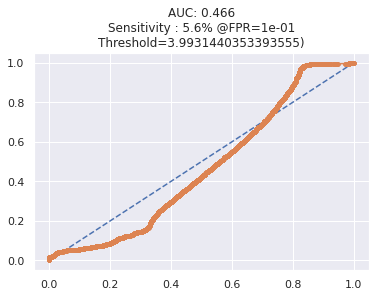

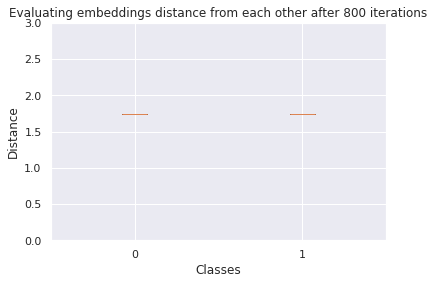


 ------------- 

[900] Time for 900 iterations: 6.2 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a65153d350>
[ 0.01311151 -0.00420138 -0.01161432  0.00733628 -0.01942038 -0.00484369
 -0.0039549  -0.00118613 -0.00222153  0.0058701   0.0097139   0.00798989
 -0.01760161  0.00166876  0.01587157 -0.01525302 -0.02852722  0.00540504
 -0.0250861   0.00107266 -0.01100854  0.00579378 -0.01830877 -0.02368823
 -0.00128102 -0.0178932  -0.01329011  0.01385622 -0.00073694  0.00502751
 -0.02624377 -0.00766501 -0.02683146 -0.02559657 -0.01512295 -0.00247787
  0.01223945  0.00099748  0.00227519 -0.01154234 -0.00537043  0.00152845
 -0.02194281 -0.01139218  0.02048582 -0.01283277  0.01378499 -0.00961926
 -0.02418169  0.01611185 -0.01702172  0.00026979 -0.01464614  0.00459383
 -0.02199732 -0.01160129  0.01712985  0.00026136 -0.00285158 -0.00549966
 -0.00377674 -0.00280547 -0.01095982  0.00810189 -0.01974324  0.00822474
 -0.00316582 -0.00148519 -0.01126447 -0.01015976  0.01146

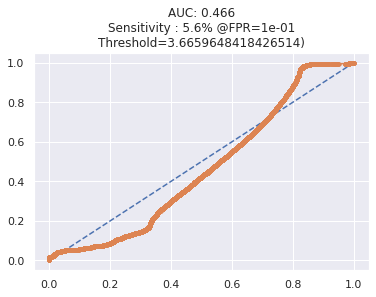

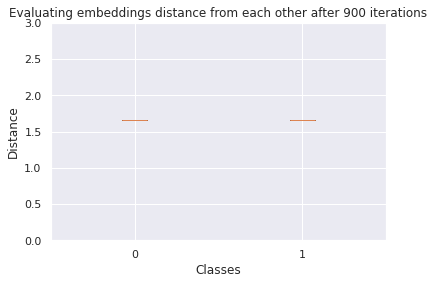


 ------------- 

[1000] Time for 1000 iterations: 6.9 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650f9bfd0>
[ 0.01293325 -0.00450088 -0.01129677  0.00670806 -0.01944932 -0.00529771
 -0.00397483 -0.00104365 -0.00225741  0.00621718  0.00942416  0.00699414
 -0.01668591  0.00223498  0.01474379 -0.01447481 -0.02736549  0.00446449
 -0.0246195   0.0007448  -0.01123069  0.00563308 -0.01810204 -0.02251867
 -0.00150732 -0.01686998 -0.01367734  0.01297746  0.00002357  0.00431602
 -0.02592798 -0.00830593 -0.02661626 -0.02452784 -0.01379008 -0.00246219
  0.01112494  0.00126646  0.00161362 -0.0119998  -0.00497239  0.00130398
 -0.02085018 -0.01128647  0.01920371 -0.01244219  0.01426812 -0.00846592
 -0.0230424   0.01440105 -0.01697487  0.00036936 -0.01592652  0.00530992
 -0.02147979 -0.01200074  0.01605033 -0.00004751 -0.00345103 -0.00434021
 -0.00295524 -0.00106878 -0.01105999  0.00787104 -0.01803241  0.00747884
 -0.00260245 -0.00148737 -0.01205112 -0.00802686  0.010

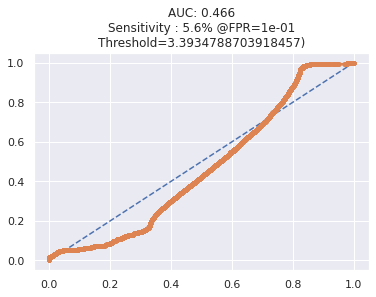

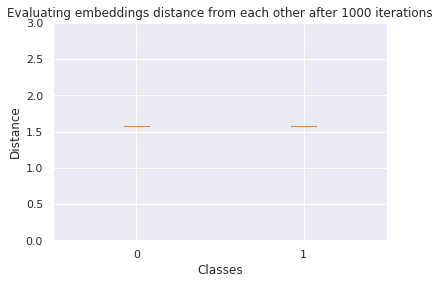


 ------------- 

[1100] Time for 1100 iterations: 7.6 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a6505f3f50>
[ 0.01216144 -0.00410514 -0.01115586  0.0060342  -0.01850838 -0.00567337
 -0.00409087 -0.00125121 -0.00105042  0.00594716  0.00889467  0.00732591
 -0.01579906  0.00188175  0.01341137 -0.01393012 -0.0263041   0.00402169
 -0.02444028  0.00024199 -0.01012102  0.00643887 -0.01772839 -0.02219838
 -0.00075419 -0.0163095  -0.01351284  0.01235725 -0.00053087  0.00362045
 -0.02469632 -0.0085318  -0.02587848 -0.02363017 -0.01302733 -0.00167229
  0.01112938  0.00049179  0.00121183 -0.01187985 -0.00429698  0.00128016
 -0.01991861 -0.01197244  0.01892471 -0.01248213  0.01391993 -0.00764388
 -0.02245297  0.01194948 -0.01623789  0.00103048 -0.0166896   0.00668053
 -0.02068746 -0.01232789  0.01476385 -0.00006788 -0.00342266 -0.00435183
 -0.0026191  -0.00067062 -0.01113435  0.00761286 -0.01677157  0.00748624
 -0.00232846 -0.00157513 -0.01317257 -0.00737595  0.010

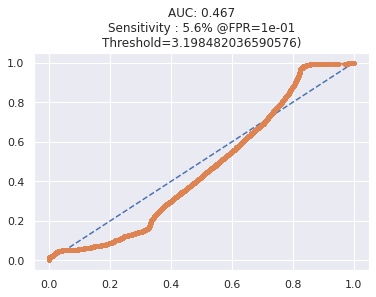

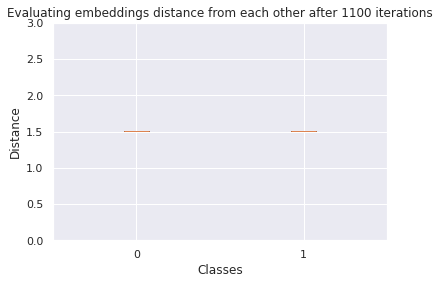


 ------------- 

[1200] Time for 1200 iterations: 8.2 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650eb2c50>
[ 0.01083806 -0.00411208 -0.01078739  0.00535383 -0.01669988 -0.00620138
 -0.00432238 -0.00062137  0.00004286  0.00613547  0.00863704  0.00747905
 -0.01458674  0.00257384  0.01310004 -0.0134351  -0.02548295  0.00461858
 -0.02341783  0.00012513 -0.00917619  0.00649148 -0.01725331 -0.02097807
 -0.00138727 -0.01492015 -0.01480115  0.01149862  0.00071714  0.00201667
 -0.02505513 -0.00755853 -0.02383067 -0.02259535 -0.01234754 -0.00179233
  0.01144762  0.00097292  0.00020393 -0.01091302 -0.00574835  0.00113399
 -0.01796521 -0.01146779  0.01693495 -0.01172425  0.01365356 -0.00610714
 -0.02169825  0.01061601 -0.01633533  0.00149822 -0.01630825  0.00677768
 -0.01893937 -0.01309377  0.01388467 -0.00078146 -0.0023676  -0.00371092
 -0.00113988 -0.00001752 -0.01093278  0.00596977 -0.01615709  0.00743062
 -0.00235739 -0.00206594 -0.01277307 -0.00555995  0.008

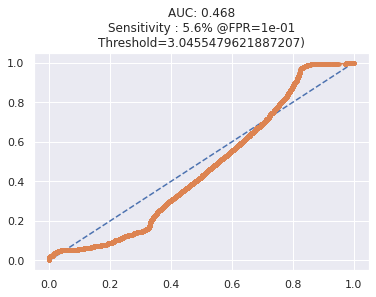

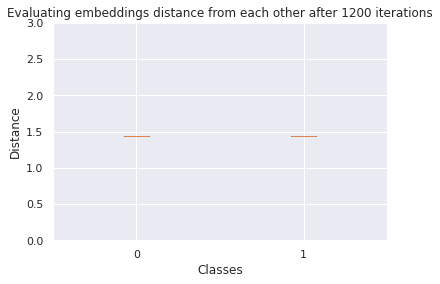


 ------------- 

[1300] Time for 1300 iterations: 8.9 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a63efb2a50>
[ 0.01012359 -0.00524551 -0.0101859   0.00459763 -0.01670856 -0.00575599
 -0.00428947 -0.00002667  0.0001495   0.00716998  0.00900056  0.00755804
 -0.01417201  0.00285143  0.01264503 -0.01295038 -0.02446068  0.00398053
 -0.02308713 -0.00019365 -0.00710778  0.00696523 -0.01634944 -0.02086841
 -0.0021623  -0.01311947 -0.01492635  0.01123055  0.00059551  0.00163784
 -0.02594018 -0.00844014 -0.02382062 -0.02237752 -0.01334915 -0.00167991
  0.0107367   0.00138138  0.00083129 -0.00969603 -0.006319    0.00210605
 -0.01684489 -0.01133784  0.01746087 -0.01225322  0.01390825 -0.00592098
 -0.02095278  0.00982361 -0.01573194  0.00130918 -0.01619714  0.00641643
 -0.01871544 -0.01404543  0.01300926 -0.00101094 -0.00148195 -0.00259146
 -0.00062843  0.00016802 -0.01077311  0.00603694 -0.01538496  0.00747017
 -0.00258041 -0.00176975 -0.01281436 -0.00558501  0.008

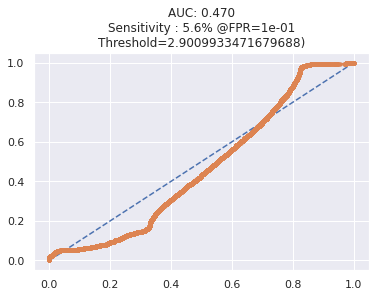

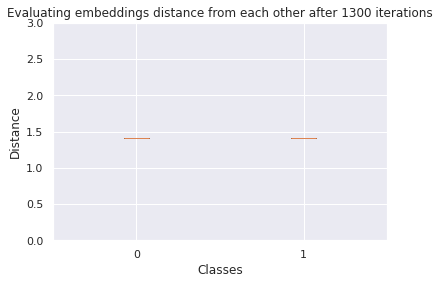


 ------------- 

[1400] Time for 1400 iterations: 9.6 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650a83110>
[ 0.00907807 -0.00454477 -0.00936591  0.00426204 -0.01586995 -0.00607054
 -0.0047469  -0.00017579  0.00106301  0.00675594  0.00917876  0.00763673
 -0.01444081  0.0014556   0.01272204 -0.01316846 -0.02360203  0.0034288
 -0.02204262 -0.00060814 -0.00749228  0.00736503 -0.01554141 -0.02056534
 -0.00233457 -0.01152904 -0.01453151  0.01205123 -0.00045995  0.00113849
 -0.02653403 -0.00880969 -0.02275003 -0.02148553 -0.01288962 -0.00279978
  0.01128442  0.00116388  0.00054324 -0.0100334  -0.00561066  0.00116928
 -0.01666509 -0.01119513  0.0168834  -0.01142658  0.01353904 -0.00544812
 -0.02063868  0.00822693 -0.01599696  0.00111472 -0.01594791  0.00697121
 -0.01727309 -0.01426863  0.01210005 -0.00121089 -0.00150816 -0.00266829
  0.00004208  0.00051897 -0.01033452  0.00477783 -0.01547115  0.0059845
 -0.00275906 -0.00214979 -0.01220068 -0.00454407  0.00694

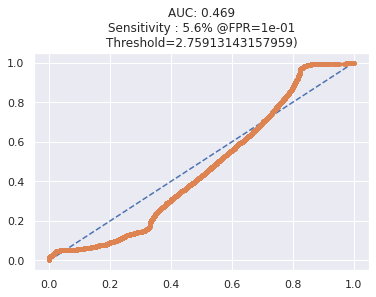

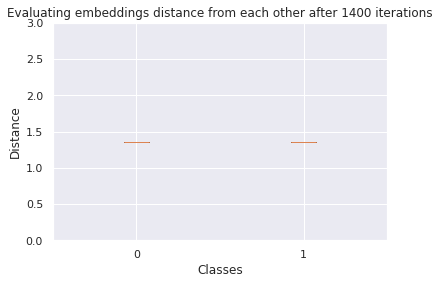


 ------------- 

[1500] Time for 1500 iterations: 10.3 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650728f90>
[ 0.00859069 -0.00350922 -0.00829642  0.00473039 -0.01408012 -0.00548618
 -0.00390015 -0.00134816  0.00157667  0.00666525  0.00866504  0.00770307
 -0.01431225  0.00037989  0.01186649 -0.0122098  -0.02283049  0.00319121
 -0.02081024 -0.00095612 -0.006671    0.00733959 -0.01457543 -0.02094799
 -0.00263719 -0.01051578 -0.01489693  0.01156088 -0.00029327  0.00083594
 -0.02670876 -0.00855649 -0.0212399  -0.02059542 -0.01233683 -0.00224382
  0.0097018   0.00180184  0.00057365 -0.00913052 -0.00592985  0.00053745
 -0.01552356 -0.0116739   0.01605977 -0.01054001  0.01431652 -0.00511009
 -0.01973725  0.00742032 -0.01597353  0.0006909  -0.01608487  0.00660112
 -0.01592658 -0.01499697  0.01133538 -0.00086251 -0.00071407 -0.00202825
  0.00077552  0.00152887 -0.01022662  0.00357724 -0.01383503  0.0055706
 -0.00281753 -0.00236282 -0.01117419 -0.00410573  0.007

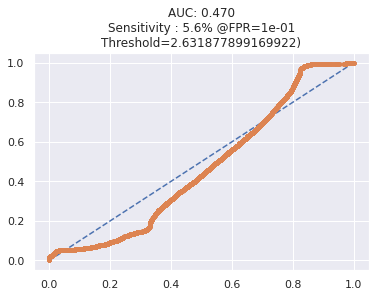

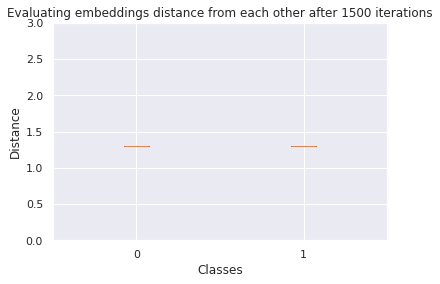


 ------------- 

[1600] Time for 1600 iterations: 11.0 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a6507b4e50>
[ 0.00801407 -0.0035652  -0.00705944  0.0047982  -0.01237866 -0.00502163
 -0.00379951 -0.00143614  0.00115335  0.00601649  0.00890866  0.0076049
 -0.01326528  0.00099703  0.01145574 -0.01250596 -0.02234143  0.00339885
 -0.01957083 -0.00125158 -0.00717101  0.00790162 -0.01395469 -0.02083253
 -0.00293338 -0.00981817 -0.0146176   0.0110148   0.00004135  0.00170758
 -0.02694874 -0.0091777  -0.02127174 -0.02080889 -0.01193531 -0.00234494
  0.00832165  0.00322216  0.00112208 -0.00942735 -0.00668559  0.0003412
 -0.01523097 -0.0114377   0.01577143 -0.01021114  0.01374577 -0.00482564
 -0.01903044  0.00597689 -0.01614533  0.00100636 -0.01622579  0.00634762
 -0.01486611 -0.01516433  0.01060346 -0.00073794 -0.0003532  -0.00131347
  0.00017436  0.00210254 -0.00933868  0.00376115 -0.01342057  0.00452656
 -0.00277653 -0.00207032 -0.00973508 -0.00429912  0.0069

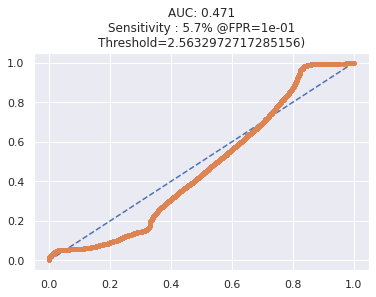

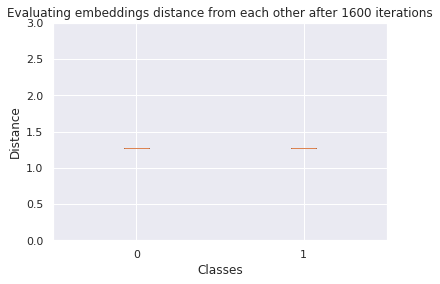


 ------------- 

[1700] Time for 1700 iterations: 11.7 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a65037ff90>
[ 0.00748315 -0.00227796 -0.00670028  0.00465001 -0.01188671 -0.00458665
 -0.00352707 -0.00093114  0.00217898  0.00613899  0.00779807  0.00811793
 -0.01208529  0.00147415  0.01078729 -0.01208418 -0.02108852  0.00376515
 -0.01860244 -0.00072609 -0.00674713  0.00761884 -0.01282091 -0.02033369
 -0.00319473 -0.00884884 -0.01441058  0.0113632  -0.00009237  0.00227314
 -0.02734659 -0.00960715 -0.02012727 -0.02052434 -0.011452   -0.00209507
  0.00798952  0.00338575  0.00119262 -0.00887063 -0.00645613 -0.00024604
 -0.01393227 -0.01085469  0.01549535 -0.0096939   0.01241225 -0.00530873
 -0.01883967  0.00441997 -0.01648999  0.00171937 -0.01606524  0.00671816
 -0.01398998 -0.0148393   0.00950394  0.00031333 -0.00099844 -0.00067901
  0.0005126   0.00304064 -0.00930159  0.00380764 -0.01295367  0.00390812
 -0.00201521 -0.00230566 -0.00950518 -0.00451111  0.00

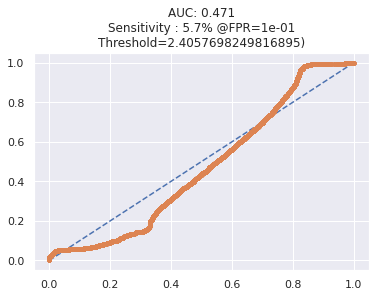

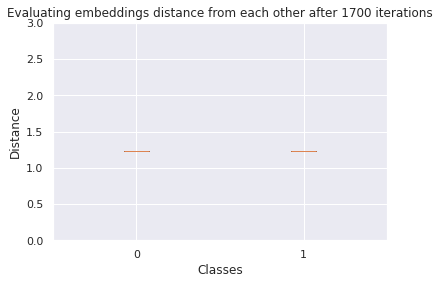


 ------------- 

[1800] Time for 1800 iterations: 12.5 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a65103c510>
[ 0.00720337 -0.00314032 -0.00591768  0.00465015 -0.0106572  -0.00460596
 -0.00312305 -0.00142231  0.00197545  0.00624053  0.00755883  0.00810232
 -0.01149354  0.00202929  0.01098008 -0.01254418 -0.02057046  0.00379678
 -0.0179303  -0.00052549 -0.00616498  0.00769229 -0.01220463 -0.02034143
 -0.00352055 -0.00878103 -0.01460249  0.0115039  -0.00071738  0.00270132
 -0.02788346 -0.00881361 -0.0195985  -0.02014654 -0.01139659 -0.00202951
  0.00736453  0.00325336  0.00087629 -0.00907503 -0.00590388  0.00030957
 -0.0131176  -0.01153024  0.01544809 -0.00964052  0.01162704 -0.00556607
 -0.01770607  0.00421772 -0.01620648  0.00178133 -0.01621986  0.00619928
 -0.01264151 -0.01524585  0.00922064 -0.00064242 -0.00099859 -0.00034768
  0.00051058  0.003724   -0.00813766  0.0041445  -0.0129051   0.00330189
 -0.00241263 -0.00293507 -0.00880835 -0.00308865  0.00

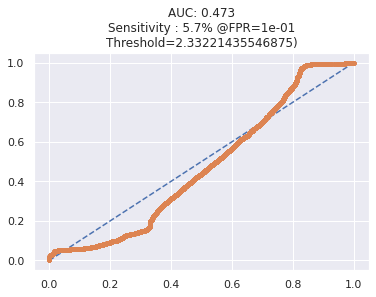

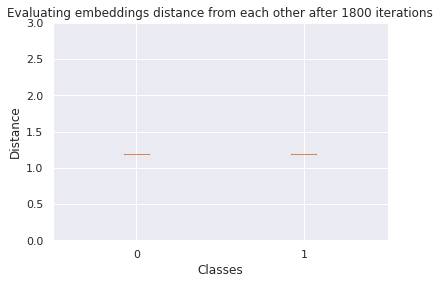


 ------------- 

[1900] Time for 1900 iterations: 13.2 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a651598f10>
[ 0.00721243 -0.00202429 -0.00566016  0.00536367 -0.01027714 -0.0049033
 -0.00309877 -0.00161918  0.00146092  0.00563753  0.00634417  0.0076532
 -0.0114702   0.00186838  0.0108505  -0.01190399 -0.02031633  0.00467826
 -0.01711643 -0.00101952 -0.00581123  0.00830744 -0.01187788 -0.02062504
 -0.00353745 -0.00869901 -0.01508566  0.01166578 -0.00126864  0.00286301
 -0.02727644 -0.00866067 -0.01859142 -0.02069891 -0.01104581 -0.00252
  0.00735174  0.00307485  0.00056254 -0.00872387 -0.00574614  0.00069789
 -0.01222727 -0.01212669  0.01534511 -0.00931743  0.01108043 -0.0055913
 -0.0170338   0.00390721 -0.01609832  0.00139458 -0.01534895  0.00570058
 -0.01193384 -0.01509182  0.00894981 -0.00064455 -0.00070605 -0.00001716
  0.00039015  0.00410851 -0.00802694  0.00404319 -0.01342401  0.00278631
 -0.00157976 -0.00300073 -0.00889924 -0.00202009  0.00426922

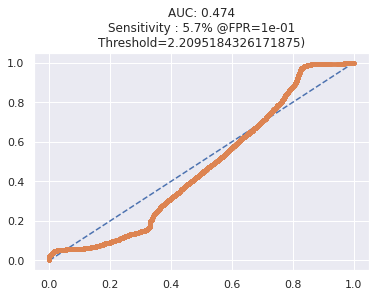

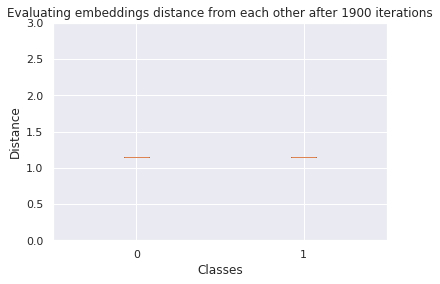


 ------------- 

[2000] Time for 2000 iterations: 13.9 mins, Train Loss: <tensorflow.python.keras.callbacks.History object at 0x14a650322210>
[ 0.00717225 -0.00170755 -0.0058766   0.00530621 -0.01035194 -0.00512327
 -0.00396197 -0.00134437  0.00129162  0.00491036  0.00534104  0.00693233
 -0.01088791  0.00234511  0.01120583 -0.01126078 -0.01975774  0.00432538
 -0.01625355 -0.00067108 -0.00588196  0.00894736 -0.01170105 -0.01970251
 -0.00419593 -0.00782778 -0.01500279  0.01154768 -0.00121761  0.00297467
 -0.02690621 -0.00853263 -0.01795262 -0.01955313 -0.01116829 -0.00272688
  0.00682695  0.00380671 -0.00122533 -0.00897646 -0.00561451  0.00068538
 -0.01245444 -0.0122917   0.01579951 -0.00840277  0.00993827 -0.00493047
 -0.01711552  0.0036979  -0.01565371  0.00253999 -0.01567808  0.0062528
 -0.01164199 -0.01373482  0.00729949 -0.00109363 -0.00112285 -0.00056188
  0.00034285  0.00412284 -0.00791928  0.00426117 -0.01291179  0.0024238
 -0.00089297 -0.00318392 -0.00879332 -0.00274587  0.0041

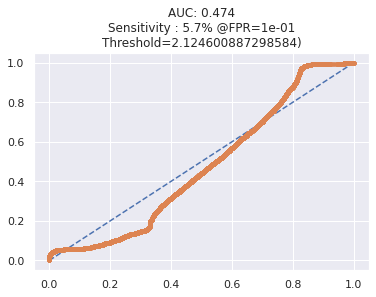

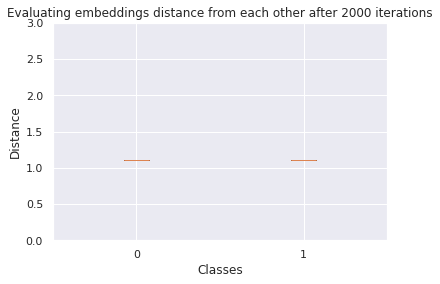

In [67]:
n_iter = 2000
def train_my_network():
    print("Starting training process!!")
    print("-------------------------------------")
    t_start = time.time()
    n_iteration=0
    #dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
    for i in range(1, n_iter+1):
        train_gen = get_triplet_batch_spoof(batch_size, X_train, Y_train, F_train)
        val_gen = triplet_generator_spoof(batch_size, X_test, Y_test, F_test)
        loss = build_triplet.fit_generator(train_gen, verbose=0)
        n_iteration += 1
        if i % 100 == 0:
            print("\n ------------- \n")
            print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}"\
                  .format(i, (time.time()-t_start)/60.0,loss,n_iteration))
            probs, yprob = compute_probs(build_embedding, X_test[:500,:,:,:,:], Y_test[:500])
            fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
            draw_roc(fpr, tpr, thresholds, auc)
            draw_interdist(build_embedding, n_iteration)
           # print("Probability " + str(probs))
           # print("YProbs " + str(yprob))
            #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
            #draw_roc(fpr, tpr)

train_my_network()

### Validation / Evaluation

In [ ]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_train[:5000,:,:,:,:], Y_train[:5000])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
labels_b = Y_test[Y_test==1]
labels_s = Y_test[Y_test==2]
X_test[labels_s.index].shape
y = labels_s.reset_index(drop=True)

In [ ]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_test[labels_s.index], y)
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_train[:2500,:,:,:,:], Y_train[:2500])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
from sklearn.metrics import roc_auc_score

def power_mean(x, p=-5):
    return np.power(np.mean(np.power(x, p)),1/p)

def get_s_auc(y_true,y_pred,y_identity):
    mask = y_identity==1
    s_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return s_auc

def get_bpsn_auc(y_true,y_pred,y_identity):
    mask = (y_identity==1) & (y_true==0) | (y_identity==0) & (y_true==1)
    bpsn_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return bpsn_auc

def get_bspn_auc(y_true,y_pred,y_identity):
    mask = (y_identity==1) & (y_true==1) | (y_identity==0) & (y_true==0)
    bspn_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return bspn_auc

def get_total_auc(y_true,y_pred,y_identities):

    N = y_identities.shape[1]
    saucs = np.array([get_s_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])
    bpsns = np.array([get_bpsn_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])
    bspns = np.array([get_bspn_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])

    M_s_auc = power_mean(saucs)
    M_bpsns_auc = power_mean(bpsns)
    M_bspns_auc = power_mean(bspns)
    rauc = roc_auc_score(y_true,y_pred)


    total_auc = M_s_auc + M_bpsns_auc + M_bspns_auc + rauc
    total_auc/= 4

    return total_auc

In [ ]:
def DrawTestImage(network, images, refidx=500):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = list_of_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:1] = list_of_test[i][refidx,:,:,:1]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        #plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        plt.matshow(images[i,:,:,0], cmap='gray')
        #sns.heatmap(images[i,:,:,0], vmin=0, vmax=5000, cmap='Greens', center=None,
           #             robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
           #             cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels=True, 
           #             yticklabels=True, mask=None, ax=None)
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            #plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            plt.matshow(ref_images[ref,:,:,0], vmin=0, vmax=200000, cmap='gray')
            #sns.heatmap(ref_images[ref,:,:,0].reshape(2,30).T, vmin=0, vmax=5000, cmap='Greens', center=None,
             #           robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
              #          cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels=True, 
               #         yticklabels=True, mask=None, ax=None)
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

In [ ]:
for i in range(2):
    DrawTestImage(build_embedding,np.expand_dims(list_of_train[i][230,:,:,:,:],axis=0))

In [ ]:
#Full evaluation
probs,yprob = compute_probs(build_embedding,X_test,Y_test)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding,n_iteration)

In [ ]:
for i in range(2):
    DrawTestImage(build_embedding,np.expand_dims(list_of_train[i][680,:,:,:],axis=0))

In [ ]:
checkpoint = ModelCheckpoint(model_cp_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)
callbacks_list = [checkpoint, early]  # early

gen_tr = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)

history = triplet_model.fit_generator(gen_tr, 
                              epochs=10, 
                              verbose=1, 
                              workers=4,
                              steps_per_epoch=200, 
                              validation_steps=20, use_multiprocessing=True)

In [ ]:
train_preds  = []
train_file_names = []
for i in range(1, n_iter+1):
    inputs, targets = data_generator(32, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1, 1)
    predicts = triplet_model.predict(inputs)
    print(predicts[0])
    predicts = predicts.tolist()
    train_preds += predicts
    targets = targets.tolist()
    train_file_names += targets
train_preds = np.array(train_preds)


test_preds  = []
test_file_names = []
for i in range(1, n_iter+1):
    inputs, targets = data_generator(32, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1, 1)
    if i % evaluate_every == 0:
        predicts = embedding_model.predict(inputs)
        predicts = predicts.tolist()
        test_preds += predicts
        targets = targets.tolist()
        test_file_names += targets
test_preds = np.array(test_preds)


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_preds)

In [ ]:
distances_test, neighbors_test = neigh.kneighbors(test_preds)
distances_test, neighbors_test = distances_test.tolist(), neighbors_test.tolist()

In [ ]:
gen_te = triplet_generator_new(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
predictions = triplet_model.embedding_model.predict(gen_te, steps=1)
print(predictions)

In [ ]:
# plt.legend()
# plt.show()
def eva_plot(History, epoch):
    plt.figure(figsize=(20,10))
#     sns.lineplot(range(1, epoch+1), History.history['acc'], label='Train Accuracy')
#     sns.lineplot(range(1, epoch+1), History.history['val_acc'], label='Test Accuracy')
#     plt.legend(['train', 'validaiton'], loc='upper left')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.show()
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['loss'], label='Train loss')
    sns.lineplot(range(1, epoch+1), History.history['val_loss'], label='Test loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()
    
eva_plot(history, 4)

def val_plot(History, epoch):
    plt.figure(figsize=(20,10))
#     sns.lineplot(range(1, epoch+1), History.history['acc'], label='Train Accuracy')
#     sns.lineplot(range(1, epoch+1), History.history['val_acc'], label='Test Accuracy')
#     plt.legend(['train', 'validaiton'], loc='upper left')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.show()
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['model_8_loss'], label='Embedding Train loss')
    sns.lineplot(range(1, epoch+1), History.history['val_model_8_loss'], label='Embedding Test loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()
    
val_plot(history, 4) 

In [ ]:
def triplet_loss1(y_true, y_pred, alpha=0.4):
    print("for distance branch, y_pred.shape:  ", y_pred)       # [Batch_dim, vec_dim*3]

    vec_len = y_pred.shape.as_list()[-1]

    anchor = y_pred[:, :int(vec_len/3)]
    positve = y_pred[:, int(vec_len/3):int(vec_len*2/3)]
    negative = y_pred[:, int(vec_len*2/3):]

    pos_dist = K.sum(K.square(anchor - positve), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    loss = K.maximum(0., pos_dist - neg_dist + alpha)

    return loss
a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    y_true = (None, None, None)
    a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)
    print(a)
    p = tf.compat.v1.random_normal([5, 60], mean=1, stddev=1, seed = 1)
    n = tf.compat.v1.random_normal([5, 60], mean=3, stddev=4, seed = 1)
    merged = concatenate([a, p, n], axis=-1)
    y_pred = (tf.compat.v1.random_normal([3, 60], mean=6, stddev=0.1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=1, stddev=1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1), 
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1))
    loss = triplet_loss1(y_true, merged)
    
    print("loss = " + str(loss.eval()))


In [ ]:
evaluate_every = 20 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 2
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)

  
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

In [ ]:
train_generator = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
val_generator = triplet_generator(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)

model.fit(generator=train_generator, steps_per_epoch=20, epochs=100,
                        validation_data=val_generator,
                        validation_steps=10,
                        verbose=1) #callbacks=[checkpoint])

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
      #  val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
       # if val_acc >= best:
        #    print("Current best: {0}, previous best: {1}".format(val_acc, best))
         #   best = val_acc

### Training 

In [ ]:
class Training_Pipeline(object):
    def __init__(self):
        self._birthdate = time.time()
        
    @staticmethod
    def get_batch(batch_size, positive_samples, negative_samples, anchor):
        """Create batch of n pairs, half same class, half different class"""
        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        # initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, w, h, 1)) for i in range(2)]

        # initialize vector for the targets
        targets=np.zeros((batch_size,))

        # make one half of it '1's, so 2nd half of batch has same class
        targets[batch_size//2:] = 1

        for i in range(batch_size):
            idx_p = rng.randint(0, n_examples_p)
            idx_n = rng.randint(0, n_examples_n)
            pairs[0][i,:,:,:] = anchor.reshape(w, h, 1)

            if i >= batch_size // 2:
                pairs[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 1)
            else:
                pairs[1][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 1)
        return pairs, targets
    
    def make_oneshot_task(self, N, positive_samples, negative_samples, anchor):
        """Create pairs of test image, support set for testing N way one-shot learning. """

        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        test_lob = np.asarray([anchor]*N).reshape(N, w, h, 1)

       # print(test_lob)

        p_index = rng.randint(0, n_examples_p, size=(1,))
        n_index = rng.randint(0, n_examples_n, size=(N,))

        support_set = negative_samples[n_index]
       # print('n_index' + str(n_index))
      #  print(support_set[0])
      #  print(support_set[1])
        support_set[0] = positive_samples[p_index]
       # print('zero now')
       # print(support_set[0])
       # print('one now')
      #  print(support_set[1])
        support_set = support_set.reshape(N, w, h, 1)

        targets = np.zeros((N,))
        targets[0] = 1     
       # print(targets)
        targets, test_lob, support_set = shuffle(targets, test_lob, support_set)
        pairs = [test_lob, support_set]
        return pairs, targets

    def test_oneshot(self, model, N, k, s = "val", verbose = 0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        inputs = []
        targets = []
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            if s == 'train':
                inputs, targets = self.make_oneshot_task(N, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
            else:
                inputs, targets = self.make_oneshot_task(N, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
            probs = model.predict(inputs)
            #print(probs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    
    def generate(batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(batch_size,s)
            yield (pairs, targets)

training_pipeline = Training_Pipeline()

In [ ]:
# Example of concat image visualization
np.set_printoptions(suppress=True)
pairs, targets = training_pipeline.make_oneshot_task(15, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs, targets, 15)
print(targets)

### Plotting LOBs

In [ ]:
def plot_oneshot_task(pairs, targets, N): 
    '''
    Only prints out one before last element of a 
    '''
    count = 0
    fig, ax = plt.subplots(2, int(N/2), sharex='col', sharey='row', figsize=(15,15))
    lob_matrix = []
    lob_matrix.append(pairs[0][0])
    for j in range(0,int(N)):
        lob_matrix.append(pairs[1][j])
     
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(lob_matrix[count][:,:,0].reshape(2,30).T, vmin=0, vmax=50000, cmap='Greens', center=None,
                        robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
                        cbar=True, cbar_kws=None, cbar_ax=cbar_ax, square=False, xticklabels=True, 
                        yticklabels=True, mask=None, ax=ax[i, j])
            count = count + 1
            print(lob_matrix[count][:,:,0])
    plt.show()

In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
   # print(pairs[0][0].shape)
    data_array = []
    data_array.append(pairs[0][0])
    #print(data_array[0][:,:,0])
    for j in range(0,int(N)):
        data_array.append(pairs[1][j])
    #print(np.moveaxis(data_array, -1, 0).shape)
   # print(data_array[0])
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(data_array[count][:,:,0].reshape(2,30).T, vmin=None, vmax=None, cmap=None, center=None,
                robust=False, annot=None, fmt='.2g', annot_kws=None, 
                linewidths=0, linecolor='white', cbar=True, cbar_kws=None, 
                cbar_ax=None, square=False, xticklabels='auto',
                yticklabels='auto', mask=None, ax=ax[i, j], **kwargs)
           # im = ax[i, j].matshow(data_array[count][:,:,0].reshape(2,30).T, cmap='BuPu')
            print(i)
            print(j)
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()


In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
    data_array = pairs[0][0]
    for j in range(0,int(N)):
        data_array = np.append(data_array, pairs[1][j], axis=-1)
    print(data_array)
    print(data_array.shape)
    print(np.moveaxis(data_array, -1, 0).shape)
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(end)):
            im = ax[i, j].matshow(pairs[initial_pair][count].reshape(2,30).T, cmap='BuPu')
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
#(j-start)*(i+1)

In [ ]:
def plot_oneshot_task(pairs, N):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=N, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1], N)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Hyper parameters
#evaluate_every = 2 # interval for evaluating on one-shot tasks
#batch_size = 32
#n_iter = 20 # No. of training iterations
#N_way = 4 # how many classes for testing one-shot tasks
#n_val = 10 # how many one-shot tasks to validate on
#best = -1
#np.set_printoptions(suppress=True)

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
model.metrics_names

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    inputs, targets = training_pipeline.get_batch(batch_size, pos_train, neg_train,\
                                                     spoof_ground_truth.spoof_step1_truth1)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = training_pipeline.test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

### Testing

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

#### Baseline model based on nearest neighbors using euclidean distance

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = training_pipeline.make_oneshot_task(N_ways,pos_val, neg_val,\
                                                            spoof_ground_truth.spoof_step1_truth1)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,15,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(training_pipeline.test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(training_pipeline.test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-------------------------------------------------------------------------------------------------------")

In [ ]:
#Save accuracies on disk
with open(os.path.join(project_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
#Load accuraces from disk
with open(os.path.join(project_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*h,n*w))
    x = 0
    y = 0
    for example in range(nc):
        img[x*h:(x+1)*h,y*w:(y+1)*w] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Example of concat image visualization
pairs, targets = training_pipeline.make_oneshot_task(1,pos_train,neg_train,spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs)

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

In [ ]:
import tensorflow_datasets as tfds

def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    train_dataset,
    epochs=5)

# Evaluate the network
results = model.predict(test_dataset)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()



from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')
  

In [ ]:
# Reasons for Choices
Normalisation - https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029
https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
https://www.jeremyjordan.me/batch-normalization/